In [1]:
import wandb
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
api = wandb.Api()
entity = "evangeorgerex"
project = "fwal"

results_dir = r'/home/er647/projects/feature-wise-active-learning/results'

In [13]:
# given a list of run ids, get the run data and return a pd df
def get_runs_data(run_ids):
    data = []
    for run_id in run_ids:
        run = api.run(f"{entity}/{project}/{run_id}")
        config = run.config
        keys = [
            "tti_valid_metrics.F1_weighted", "tti_test_metrics.F1_weighted", "num_additional_features"
            ]
        for row in run.scan_history(keys=keys):
            history = {}
            for key in keys:
                history[key] = row[key]
            history['dataset'] = config["dataset"]
            data.append(history)
    
    # Concatenate all the dataframes into a single dataframe
    return pd.DataFrame(data)

def plot_tti_dataset(df: pd.DataFrame, dataset: str):
    # y axis: tti_test_metrics.F1_weighted
    # x axis: num_additional_features
    # line plot using seaborn. Filter by dataset
    df = df[df["dataset"] == dataset]
    sns.lineplot(x="num_additional_features", y="tti_test_metrics.F1_weighted", data=df)

def plot_tti_all_datasets(df: pd.DataFrame):
    # Create a FacetGrid to plot a grid of line plots
    # Each subplot will have its own scaling
    g = sns.FacetGrid(df, col="dataset", col_wrap=4, height=3, aspect=1.5, sharex=False, sharey=False)
    g.map_dataframe(sns.lineplot, x="num_additional_features", y="tti_test_metrics.F1_weighted")
    
    # Add a single legend to the right of the entire grid
    g.add_legend(title="F1 Weighted Score", bbox_to_anchor=(1.05, 0.5), loc='center left')
    
    # Adjust layout to make room for the legend outside the plot area
    g.fig.subplots_adjust(right=0.85)  # adjust this value as needed to fit your display
    
    # Show the plot
    plt.show()

def plot_smoothed_tti(df: pd.DataFrame, top_models_df: pd.DataFrame, window_size=5, save=False):
    # Prepare a grid of plots
    # datasets = df['dataset'].unique()
    datasets = ['PBMC', 'COIL20', 'mice_protein', 'Isolet', 'USPS', 'finance', 'madelon']
    n_datasets = len(datasets)
    n_cols = 4
    n_rows = (n_datasets + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3), sharex=False, sharey=False)
    axes = axes.flatten()
    color_map = {
        'MLP': 'b',
        'xgboost': 'r',
        'lasso': 'g',
        'rf': 'y',
        'SEFS': 'm',
        'cae': 'c'
        }
        
    # Iterate over each dataset
    handles = []
    labels = []
    for i, dataset in enumerate(datasets):
        ax = axes[i]
        # Filter data for the current dataset
        data = df[df['dataset'] == dataset]
        # Sort data by x values if not already
        data = data.sort_values(by="num_additional_features")
        x = data["num_additional_features"]
        y = data["tti_test_metrics.F1_weighted"]
        
        # Compute rolling mean and standard deviation
        y_smoothed = y.rolling(window=window_size, center=False).mean()
        y_std = y.rolling(window=window_size, center=False).std()
        
        # Plot smoothed line and error bars
        ax.plot(x, y_smoothed, label='F-Act (Ours)', color='black')
        ax.fill_between(x, y_smoothed - y_std, y_smoothed + y_std, alpha=0.2, color='gray')
        
        # Plot top model scores as horizontal lines with labels
        top_scores = top_models_df[top_models_df['dataset'] == dataset]
        for idx, row in top_scores.iterrows():
            ax.axhline(y=row['score'], color=color_map[row['model']], linestyle='--', linewidth=1, label=row['model'])
        
        # Customize each subplot
            # Set subplot title and labels
        title_map = {
            'USPS': 'USPS', 
            'mice_protein': 'Mice Protein', 
            'Isolet': 'Isolet', 
            'madelon': 'Madelon', 
            'COIL20': 'COIL20', 
            'PBMC': 'PBMC',
            'finance': 'Finance'
        }
        ax.set_title(title_map[dataset])
        ax.set_xlabel('Number of Additional Features')
        ax.set_ylabel('F1 Weighted Score')
        
        handle, label = ax.get_legend_handles_labels()
        handles.extend(handle)
        labels.extend(label)
    
    last_ax = axes[-1]
    last_ax.axis('off')
    
    # Adjust layout and handle legend
    # Ensure all subplots have room for the legend
    fig.subplots_adjust(right=0.85)
    
    labels_and_handles_dict =  {}
    for i, label in enumerate(labels):
        labels_and_handles_dict[label] = handles[i]
    labels, handles = zip(*labels_and_handles_dict.items())
            
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.825, 0.275), title="Legend")
    
    fig.tight_layout()
    if save:
        plt.savefig(f"{results_dir}/tti_plot.png")
    plt.show()


# F-Act

In [4]:

run_ids = [
    "bfi5l6qu" , # COIL20
    "ihpfigr4" , # COIL20
    "rhrqy9bb" , # COIL20
    
    "sj64pl05" , # Isolet
    "dtv0wjox" , # Isolet
    "gp378vp4" , # Isolet
    
    "vqcdnueq" , # PBMC
    # '3e7c2ala' , # PBMC
    # '9qx2b2na' , # PBMC
    
    "b8nrupvc" , # USPS
    "rcacu3yt" , # USPS
    "swbk9dsz" , # USPS
    
    "sawnisk5" , # finance
    "dqq6q5ej" , # finance
    "33iwvq59" , # finance
    
    "ko5c4p3v" , # madelon
    "h4m5vvcm" , # madelon
    "zyuohsyk" , # madelon
    
    "5le875vr" , # mice_protein
    "6utw0s44" , # mice_protein
    "r46u12zd" , # mice_protein
    
    "n0mcba2f" , # poly_binarised_decimalised_synth
    "94j8ch8b" , # poly_binarised_decimalised_synth
    "qskac7qn" , # poly_binarised_decimalised_synth
]

## Get df

In [40]:
# df = get_runs_data(run_ids)

In [42]:
# save df to csv
# df.to_csv(f"{results_dir}/tti_test_metrics.csv", index=False)

In [5]:
# load df from csv
df = pd.read_csv(f"{results_dir}/tti_test_metrics.csv")

In [6]:
df = df[df['dataset'] != 'poly_binarised_decimalised_synth']

In [10]:
import pandas as pd

# Data in dictionary format
data = {
    'dataset': ['F-Act', 'F-Act (full TTI)', 'F-Act (optimal TTI)', 'MLP', 'SEFS', 'cae', 'lasso', 'rf', 'supervised_cae', 'xgboost'],
    'COIL20': [0.986039, 0.982608, 0.988419, 0.988311, 0.949701, 0.970427, 0.982413, 0.967561, 0.064637, 0.986075],
    'Isolet': [0.919675, 0.928581, 0.928581, 0.934809, 0.886111, 0.801414, 0.945832, 0.900926, 0.036833, 0.887528],
    'PBMC': [0.831719, 0.913124, 0.898703, 0.894191, 0.831686, 0.680679, 0.892459, 0.886592, 0.853663, 0.894172],
    'USPS': [0.968292, 0.960261, 0.959526, 0.967768, 0.925440, 0.904749, 0.933578, 0.933634, 0.209018, 0.973689],
    'finance': [0.602923, 0.599476, 0.598131, 0.570214, 0.599271, 0.592564, 0.597777, 0.619456, 0.544434, 0.588311],
    'madelon': [0.722480, 0.702223, 0.729048, 0.571757, 0.652284, 0.701883, 0.515320, 0.671901, 0.618427, 0.809609],
    'mice_protein': [0.978486, 0.989209, 0.989209, 0.9803, 0.850778, 0.853472, 0.952401, 0.969803, 0.172394, 0.980]
}

# Convert dictionary to DataFrame
baseline_df = pd.DataFrame(data)



In [11]:
df_transposed = baseline_df.set_index('dataset').transpose()
df_long = df_transposed.reset_index().melt(id_vars=['index'], var_name='model', value_name='score')
df_long.rename(columns={'index': 'dataset'}, inplace=True)
# Assuming df_long is the DataFrame in long format containing 'dataset', 'model', 'score'

df_long = df_long[(df_long['model'] != 'F-Act') & (df_long['model'] != 'F-Act (optimal TTI)') & (df_long['model'] != 'F-Act (full TTI)')]
# Group by 'dataset' and get the top 3 models based on 'score'
top_models = df_long.groupby('dataset').apply(lambda x: x.nlargest(3, 'score')).reset_index(drop=True)

## Plot

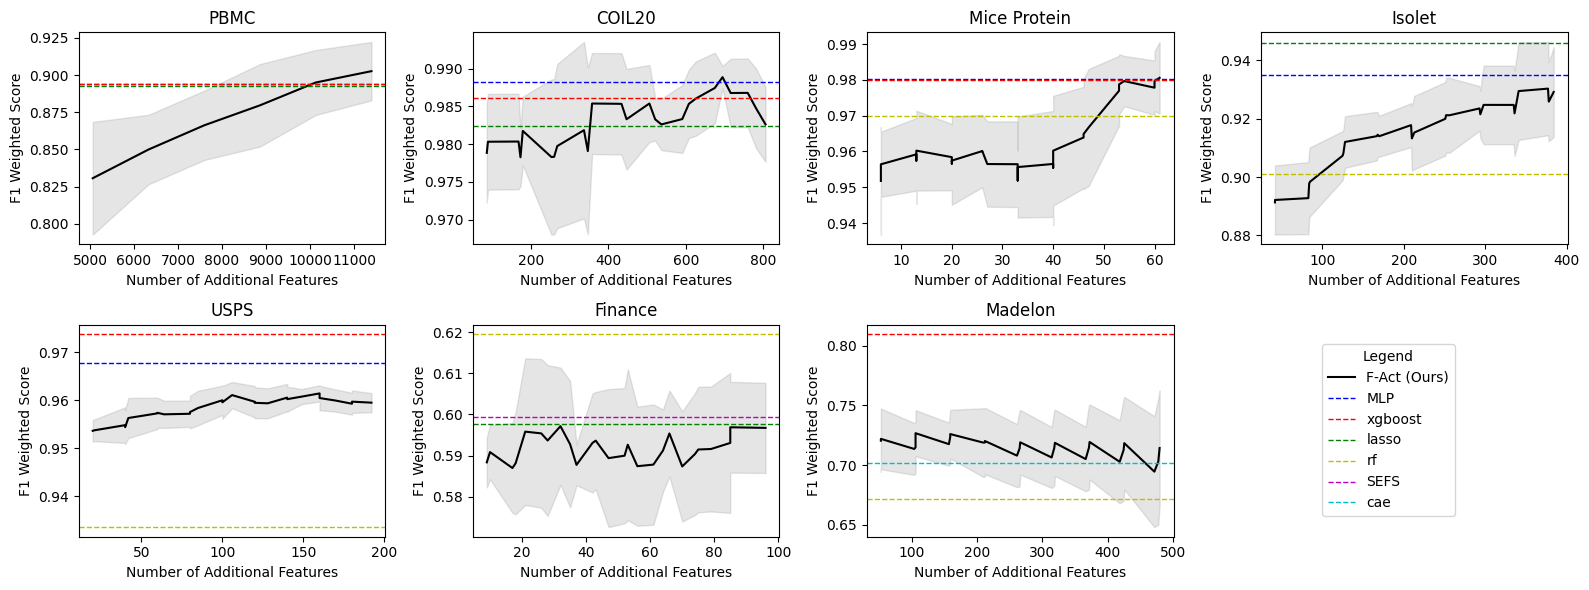

In [14]:
plot_smoothed_tti(df, top_models, save=True)


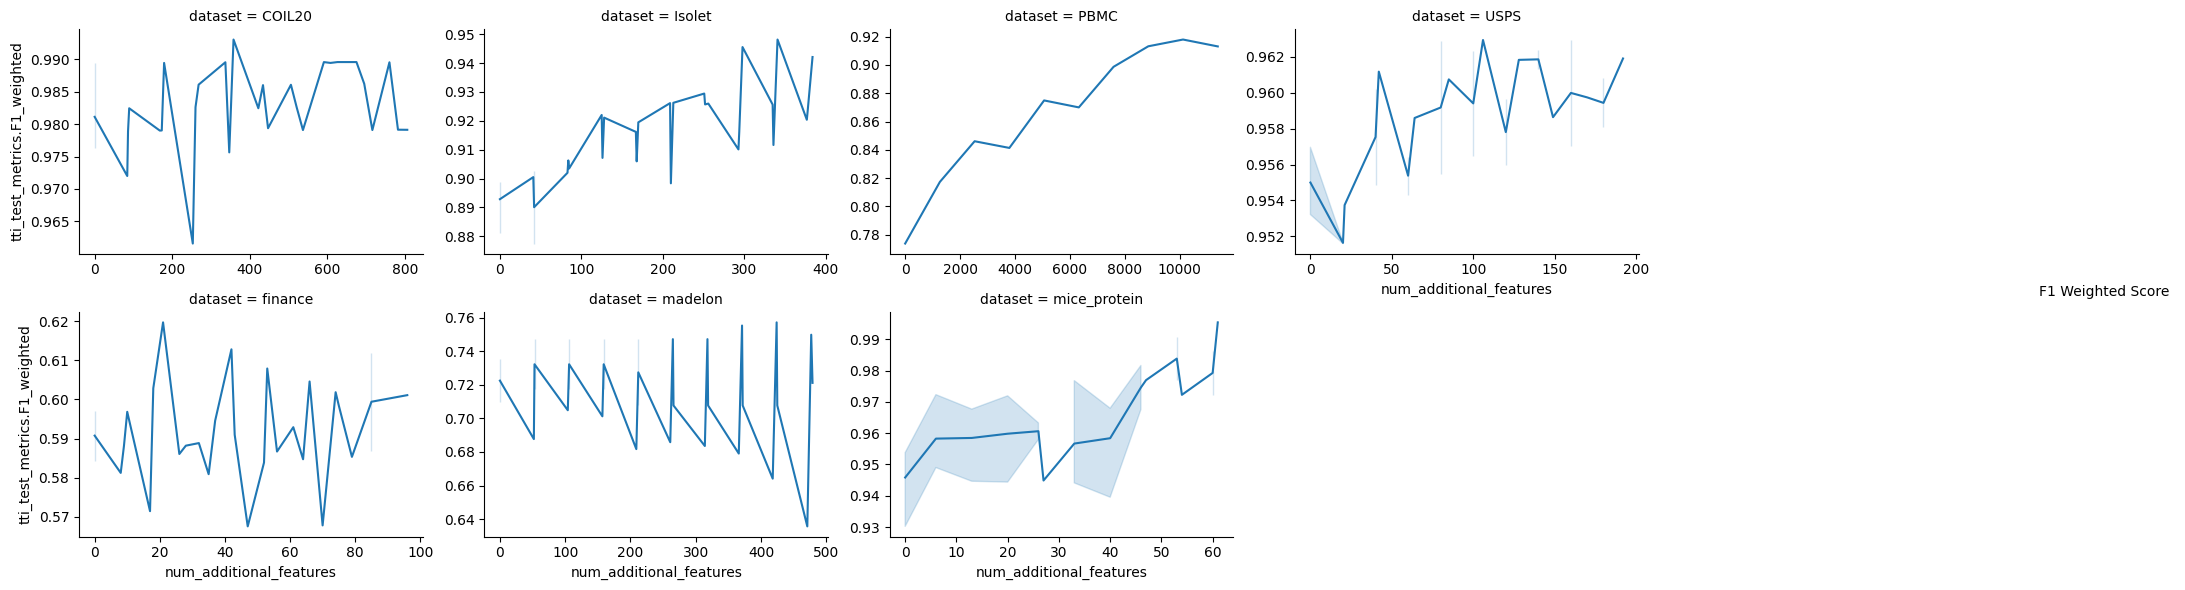

In [ ]:
plot_tti_all_datasets(df)

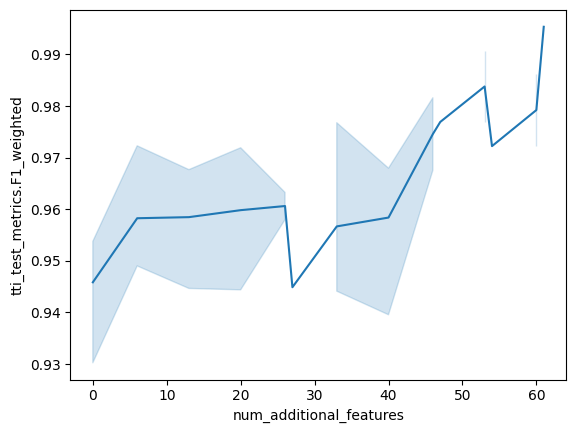

In [37]:
plot_tti_dataset(df, 'mice_protein')